# Data Preprocess

- Input: 
    * customer_purchase_dataset
    * order_payments_dataset
    * order_reviews_dataset
    * orders_dataset
    * customers_dataset
- Output:
    * customer_analysis_input

## Import all necessary libraries

In [1]:
#!fc-list :lang=zh family

In [2]:
import os
import glob
from functools import reduce
#import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy import stats
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#pd.set_option('display.max_rows', 10)
plt.rcParams['font.sans-serif'] = ['Noto Sans Mono CJK TC', 'sans-serif'] 
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

## Load Data

In [3]:
try:
    from google.colab import drive

    # Mount the folder "drive" on google drive to Colab Notebook
    drive.mount('/content/drive')
    path = '/content/drive/My Drive/wids-taipei/2020-WiDS-Taipei-MLCC-Workshop/dataset/*.csv'
except ModuleNotFoundError:
    path = '../data/*.csv'

### Read data

In [4]:
# Read data
filenames = glob.glob(path)
pd_dict = {}

for filename in filenames:
    name = filename.split("/")[-1].split(".")[0]
    pd_dict[name] = pd.read_csv(os.path.join(filename))

purchase_data = pd_dict['customer_purchase_dataset']    
payments_data = pd_dict['order_payments_dataset']
reviews_data = pd_dict['order_reviews_dataset']
orders_data = pd_dict['orders_dataset']
customers_data = pd_dict['customers_dataset']

## Data Exploration

- customer_purchase_dataset
- order_payments_dataset
- order_reviews_dataset

### Customer Purchase Dataset

- customer_unique_id: unique identifier of a customer
- product_sub_category
- product_main_category
- price: item price
- cnt: number of items include in the same order.

In [5]:
# 236835 rows × 5 columns
purchase_data

,customer_unique_id,product_sub_category,product_main_category,price,count
0,7ad04c71bfca958e6f2ec44bce34e2da,books_technical,書籍,24.0,1
1,4e58455924b97da4c44477abb0b030a5,cool_stuff,休閒生活,44.9,1
2,1f44054faaecb5ba43ca49625fb81767,auto,3C,24.8,1
3,d8764626d0d43e3f4fb34db9021a46ef,kitchen_dining_laundry_garden_furniture,家居生活,9.6,1
4,960438e3b93de6c449d45491534855a2,computers_accessories,3C,89.8,1
...,...,...,...,...,...
236830,305adb7f869f2d07fa2170b042abefdf,bed_bath_table,家居生活,137.9,1
236831,49edfe73ea287d715eebfced06b0bea9,auto,3C,139.0,1
236832,d87cc9520e3fd47ef88f7098e51afe8a,health_beauty,保健,325.0,1
236833,738ffcf1017b584e9d2684b36e07469c,fashion_underwear_beach,服飾/配件,155.0,1


In [6]:
purchase_data.isnull().sum()

customer_unique_id          0
product_sub_category     1567
product_main_category       0
price                       0
count                       0
dtype: int64

In [7]:
purchase_data.product_sub_category = purchase_data.product_sub_category.fillna('other')
purchase_data.isnull().sum()

customer_unique_id       0
product_sub_category     0
product_main_category    0
price                    0
count                    0
dtype: int64

In [8]:
purchase_data.describe()

,price,count
count,236835.000000,236835.0
mean,161.052777,1.0
std,373.447874,0.0
min,0.850000,1.0
25%,39.990000,1.0
50%,79.900000,1.0
75%,149.000000,1.0
max,6735.000000,1.0


#### Visualize

Total main categories:  14


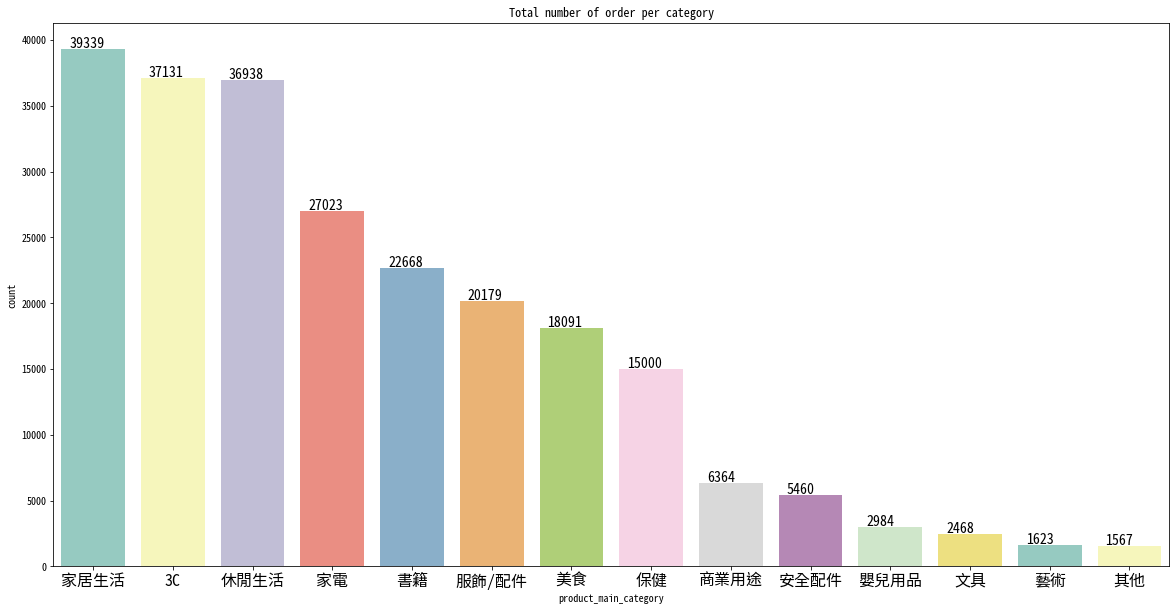

In [9]:
# visualize
plt.figure(figsize=(20, 10))
ax = sns.countplot(x="product_main_category",
                   data=purchase_data,
                   order=purchase_data['product_main_category'].value_counts().sort_values(ascending=False).index,
                   palette='Set3')
plt.xticks(fontsize=16)
plt.title("Total number of order per category")

# labels values
for p in ax.patches:
    value = int(p.get_height())
    x = p.get_x() + (p.get_width() / 2) - 0.3
    y = p.get_y() + p.get_height() + 100
    ax.text(x, y, str(value), fontsize=14)

print("Total main categories: ", len(purchase_data['product_main_category'].unique()))

#### Data clean

In [10]:
def clean_purchase_data(df):    
    aggregations = {
      'count': 'sum',
      'price': 'sum' 
    }
    
    # 1. Calculate the sum of the price and order per category on every customer
    ## groupby: 'customer_unique_id' and 'product_main_category'
    purchase_prod_price = df.groupby(['customer_unique_id', 'product_main_category']) \
        .agg(aggregations).reset_index()
    purchase_prod_price = purchase_prod_price.rename(
        columns={'count': 'item_count', 'price': 'total_price'})
    
    ## pivot table: customer - category
    purchase_price_pivot = pd.pivot_table(purchase_prod_price, 
                                          index=['customer_unique_id'],
                                          columns='product_main_category')
    purchase_price_pivot.columns = list(map("_".join, purchase_price_pivot.columns))
    
    # 2. The total cost on every customer
    customer_price = df.groupby(['customer_unique_id']).agg(aggregations).reset_index()
    customer_price = customer_price.rename(
        columns={'count': 'item_count', 'price': 'total_price'})
    
    # 3. Merge
    purchase_result = pd.merge(customer_price, purchase_price_pivot, on='customer_unique_id')
    purchase_result = purchase_result.replace({np.nan:0})
    
    return purchase_result

In [11]:
purchase_result = clean_purchase_data(purchase_data)
purchase_result

,customer_unique_id,item_count,total_price,item_count_3C,item_count_休閒生活,item_count_保健,item_count_其他,item_count_商業用途,item_count_嬰兒用品,item_count_安全配件,...,total_price_商業用途,total_price_嬰兒用品,total_price_安全配件,total_price_家居生活,total_price_家電,total_price_文具,total_price_書籍,total_price_服飾/配件,total_price_美食,total_price_藝術
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,129.90,0.00,0.0,0.00,0.0,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2,143.90,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,125.00,0.0,0.0,0.0
2,0000f46a3911fa3c0805444483337064,3,280.89,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,69.0,44.90,0.0,0.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,2,125.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,99.99,25.99,0.0,0.00,0.0,0.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,3,314.89,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,49.9,0.00,84.99,0.00,180.00,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93345,fffcf5a5ff07b0908bd4e2dbc735a684,4,1728.00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,77.00,0.0,81.0,0.0
93346,fffea47cd6d3cc0a88bd621562a9d061,1,64.89,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,64.89,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0
93347,ffff371b4d645b6ecea244b27531430a,4,411.64,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,137.94,0.0,100.0,0.0
93348,ffff5962728ec6157033ef9805bacc48,1,115.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0


### Payments Dataset

- order_id: 
    unique identifier of an order.
    
- payment_sequential: 
    a customer may pay an order with more than one payment method. If he does so, a sequence will be created to accommodate all payments.
    
- payment_type:
    method of payment chosen by the customer.
    
- payment_installments:
    number of installments chosen by the customer.

- payment_value:
    transaction value.

- payment_count

In [12]:
payments_data

,order_id,payment_sequential,payment_type,payment_installments,payment_value,payment_count
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,1
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,1
...,...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31,1
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80,1
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77,1
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54,1


In [13]:
payments_data.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
payment_count           0
dtype: int64

In [14]:
payments_data.groupby('payment_type').size()

payment_type
boleto         19784
credit_card    76795
debit_card      1529
not_defined        3
voucher         5775
dtype: int64

#### Visualize

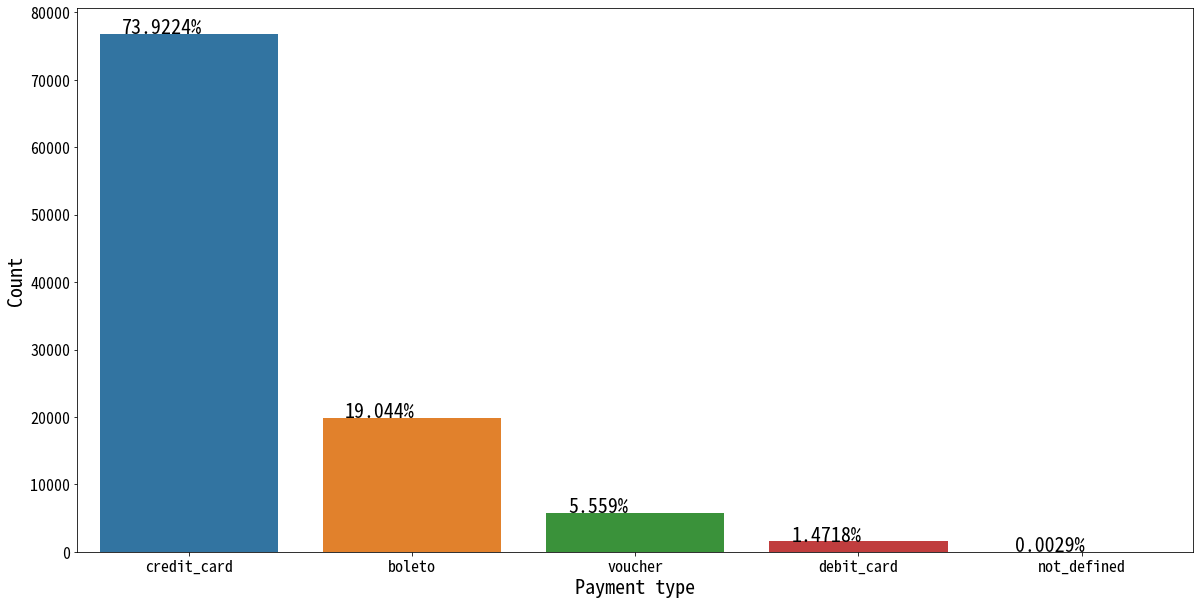

In [15]:
# visualize
plt.figure(figsize=(20, 10))
ax = sns.countplot(x='payment_type', data=payments_data)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Payment type", fontsize=20)
plt.ylabel("Count", fontsize=20)

# labels values
total = len(payments_data['order_id'])
for p in ax.patches:
    value = round((p.get_height() / total) * 100, 4)
    x = p.get_x() + (p.get_width() / 2) - 0.3
    y = p.get_y() + p.get_height() + 100
    ax.text(x, y, str(value) + '%', fontsize=20)

#### Data clear

In [16]:
def clean_payments_data(df):
    payment_type_replace = {
        'credit_card':'credit_card', 
        'boleto':'boleto', 
        'voucher':'others',
        'debit_card':'others',
        'not_defined':'others'
    }
    
    # 1. Change payment type
    df['payment_type_new'] = df['payment_type'].map(payment_type_replace)
    df_update = df[['order_id', 'payment_type_new', 'payment_installments', 'payment_value', 'payment_count']]
    
    # 2. Groupby
    aggregations = {
        'payment_installments': 'sum',
        'payment_value': 'sum', 
        'payment_count': 'sum'
    }
    df_update = df_update.groupby(['order_id', 'payment_type_new'], as_index=False).agg(aggregations)
    
    # 3. pivot table
    df_pivot = pd.pivot_table(df_update, index=['order_id'],
                              columns='payment_type_new')
    df_pivot.columns = list(map("_".join, df_pivot.columns))
    
    #
    payments_result = pd.DataFrame(df_pivot.to_records())
    payments_result = payments_result.iloc[:, [0,1,2,3,5,7,8,9]]
    payments_result['total_value'] = payments_result.payment_value_boleto.fillna(0) \
                                   + payments_result.payment_value_credit_card.fillna(0) \
                                   + payments_result.payment_value_others.fillna(0)

    return payments_result

In [17]:
payments_result = clean_payments_data(payments_data)
payments_result

,order_id,payment_count_boleto,payment_count_credit_card,payment_count_others,payment_installments_credit_card,payment_value_boleto,payment_value_credit_card,payment_value_others,total_value
0,00010242fe8c5a6d1ba2dd792cb16214,NaN,1.0,NaN,2.0,NaN,72.19,NaN,72.19
1,00018f77f2f0320c557190d7a144bdd3,NaN,1.0,NaN,3.0,NaN,259.83,NaN,259.83
2,000229ec398224ef6ca0657da4fc703e,NaN,1.0,NaN,5.0,NaN,216.87,NaN,216.87
3,00024acbcdf0a6daa1e931b038114c75,NaN,1.0,NaN,2.0,NaN,25.78,NaN,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,NaN,1.0,NaN,3.0,NaN,218.04,NaN,218.04
...,...,...,...,...,...,...,...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,1.0,NaN,NaN,NaN,343.40,NaN,NaN,343.40
99436,fffcd46ef2263f404302a634eb57f7eb,1.0,NaN,NaN,NaN,386.53,NaN,NaN,386.53
99437,fffce4705a9662cd70adb13d4a31832d,NaN,1.0,NaN,3.0,NaN,116.85,NaN,116.85
99438,fffe18544ffabc95dfada21779c9644f,NaN,1.0,NaN,3.0,NaN,64.71,NaN,64.71


### Reviews Dataset

- review_id:
    unique review identifier

- order_id:
    unique order identifier
    
- review_score:
    Note ranging from 1 to 5 given by the customer on a satisfaction survey.
    
- review_comment_title:
    Comment title from the review left by the customer, in Portuguese.

- review_comment_message:
    Comment message from the review left by the customer, in Portuguese.

- review_creation_date:
    Shows the date in which the satisfaction survey was sent to the customer.

- review_answer_timestamp:
    Shows satisfaction survey answer timestamp.

In [18]:
reviews_data

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,NaN,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


In [19]:
reviews_data.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

#### Visualize

#### Data clean

In [20]:
def clean_reviews_data(df):
  order_reviews_update = df[df.groupby('order_id').review_answer_timestamp.transform('max') == df['review_answer_timestamp']]
  order_reviews_group = df.groupby('order_id')['review_comment_message'].apply(lambda x: ','.join(x.astype(str))).reset_index()
  order_reviews_group.review_comment_message.replace('nan', np.nan, inplace=True)
  order_reviews_group[['review_comment_message']] = order_reviews_group[['review_comment_message']].applymap(lambda x: 0 if pd.isnull(x) else 1)
  order_reviews_result = pd.merge(order_reviews_update[['order_id', 'review_score', 'review_answer_timestamp']], order_reviews_group, on='order_id',how='left')
  return order_reviews_result

In [21]:
def clean_reviews_data(df):
    # 1. Only need the review that is the laste time
    df_update = df[df.groupby('order_id').review_answer_timestamp.transform('max') \
                   == df['review_answer_timestamp']]
    
    # 2. Group: order_id -> change type to str        
    df_group = df.groupby('order_id')['review_comment_message'] \
        .apply(lambda x: ','.join(x.astype(str))).reset_index()
    df_group.review_comment_message.replace('nan', np.nan, inplace=True)
    
    ## change to binary encode:
    ##     if have comment ->1, else -> 0
    df_group[['review_comment_message']] = df_group[['review_comment_message']] \
        .applymap(lambda x: 0 if pd.isnull(x) else 1)
    
    # 3. result
    reviews_result = pd.merge(df_update[['order_id', 'review_score', 'review_answer_timestamp']], 
                              df_group, 
                              on='order_id',how='left')
    
    return reviews_result

In [22]:
reviews_result = clean_reviews_data(reviews_data)
reviews_result

,order_id,review_score,review_answer_timestamp,review_comment_message
0,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 21:46:59,0
1,a548910a1c6147796b98fdf73dbeba33,5,2018-03-11 03:05:13,0
2,f9e4b658b201a9f2ecdecbb34bed034b,5,2018-02-18 14:36:24,0
3,658677c97b385a9be170737859d3511b,5,2017-04-21 22:02:06,1
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,2018-03-02 10:26:53,1
...,...,...,...,...
99436,22ec9f0669f784db00fa86d035cf8602,5,2017-12-11 20:06:42,0
99437,55d4004744368f5571d1f590031933e4,5,2018-03-23 09:10:43,1
99438,7725825d039fc1f0ceb7635e3f7d9206,4,2018-07-02 12:59:13,0
99439,f8bd3f2000c28c5342fedeb5e50f2e75,1,2017-12-16 01:29:43,1


## Join table

Because `order_payment_result` and `order_reviews_result` don't have `customer_unique_id`,
so we need `order_dataset`.

In [23]:
orders_data.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [24]:
# __join_table__
order_join_df = [orders_data, payments_result, reviews_result]

## mrege: use python's reduction
order_detail = reduce(lambda left, right: pd.merge(left, right, on='order_id', how='left'), order_join_df)
## We only need is delivered data.
order_detail = order_detail.loc[order_detail['order_status'] == 'delivered']

## replace miss value to 0
replace_cols = [
    "payment_count_boleto",
    "payment_count_credit_card",
    "payment_count_others",
    "payment_installments_credit_card",
    "payment_value_boleto",
    "payment_value_credit_card",
    "payment_value_others"]
order_detail[replace_cols] = order_detail[replace_cols].replace({np.nan:0})

## replace timestep format
order_detail['order_purchase_timestamp'] =  pd.to_datetime(order_detail['order_purchase_timestamp'], 
                                                           format='%Y-%m-%d %H:%M:%S')
order_detail['order_delivered_customer_date'] =  pd.to_datetime(order_detail['order_delivered_customer_date'], 
                                                                format='%Y-%m-%d %H:%M:%S')
order_detail['review_answer_timestamp'] =  pd.to_datetime(order_detail['review_answer_timestamp'], 
                                                          format='%Y-%m-%d %H:%M:%S')

## calculate receive waiting day
order_detail['receive_waiting_day'] = order_detail['order_delivered_customer_date'] \
    .sub(order_detail['order_purchase_timestamp'], axis=0)
order_detail['receive_waiting_day'] = order_detail['receive_waiting_day'] / np.timedelta64(1, 'D')

## calculate review waiting day
order_detail['review_waiting_day'] = order_detail['review_answer_timestamp'] \
    .sub(order_detail['order_purchase_timestamp'], axis=0)
order_detail['review_waiting_day'] = order_detail['review_waiting_day'] / np.timedelta64(1, 'D')
order_detail

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_count_boleto,payment_count_credit_card,...,payment_installments_credit_card,payment_value_boleto,payment_value_credit_card,payment_value_others,total_value,review_score,review_answer_timestamp,review_comment_message,receive_waiting_day,review_waiting_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,0.0,1.0,...,1.0,0.00,18.12,20.59,38.71,4,2017-10-12 03:43:48,1,8.436574,9.699479
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,0.0,...,0.0,141.46,0.00,0.00,141.46,4,2018-08-08 18:37:50,1,13.782037,14.914039
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,0.0,1.0,...,3.0,0.00,179.12,0.00,179.12,5,2018-08-22 19:07:58,0,9.394213,14.436910
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,0.0,1.0,...,1.0,0.00,72.20,0.00,72.20,5,2017-12-05 19:21:58,1,13.208750,16.995741
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,0.0,1.0,...,1.0,0.00,28.62,0.00,28.62,5,2018-02-18 13:02:51,0,2.873877,4.655694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,0.0,1.0,...,3.0,0.00,85.08,0.00,85.08,5,2017-03-23 11:02:08,0,8.218009,14.047257
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,0.0,1.0,...,3.0,0.00,195.00,0.00,195.00,4,2018-03-02 17:50:01,1,22.193727,24.202118
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,0.0,1.0,...,5.0,0.00,271.01,0.00,271.01,5,2017-09-22 23:10:57,1,24.859421,26.350162
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,0.0,1.0,...,4.0,0.00,441.16,0.00,441.16,2,2018-01-27 09:16:56,1,17.086424,18.492002


In [25]:
# 因客戶購買多次會有多個購買區域，選取最近一次購買之區域
customers_update = pd.merge(customers_data, 
                            orders_data[['order_id','customer_id','order_purchase_timestamp']], 
                            on='customer_id', how='left')
customers_update = customers_update[['customer_unique_id', 'customer_city', 'customer_state','order_purchase_timestamp']]
customers_update.drop_duplicates(subset=None, keep='first', inplace=True)
customers_update_result = customers_update[customers_update.groupby('customer_unique_id').order_purchase_timestamp.transform('max') == customers_update['order_purchase_timestamp']]
customers_update_result = customers_update_result[['customer_unique_id', 'customer_city', 'customer_state']]
customers_update_result

,customer_unique_id,customer_city,customer_state
0,861eff4711a542e4b93843c6dd7febb0,franca,SP
1,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP
2,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP
3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,SP
4,345ecd01c38d18a9036ed96c73b8d066,campinas,SP
...,...,...,...
99436,1a29b476fee25c95fbafc67c5ac95cf8,sao paulo,SP
99437,d52a67c98be1cf6a5c84435bd38d095d,taboao da serra,SP
99438,e9f50caf99f032f0bf3c55141f019d99,fortaleza,CE
99439,73c2643a0a458b49f58cea58833b192e,canoas,RS


In [26]:
# 串customer_unique_id
order_customer_join = pd.merge(order_detail, 
                               customers_data[['customer_id','customer_unique_id']], 
                               on='customer_id', how='left')
customer_city_result = pd.merge(purchase_result, 
                                customers_update_result, 
                                on='customer_unique_id', how='left')

In [27]:
order_customer_join.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_count_boleto,payment_count_credit_card,...,payment_value_boleto,payment_value_credit_card,payment_value_others,total_value,review_score,review_answer_timestamp,review_comment_message,receive_waiting_day,review_waiting_day,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,0.0,1.0,...,0.00,18.12,20.59,38.71,4,2017-10-12 03:43:48,1,8.436574,9.699479,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,0.0,...,141.46,0.00,0.00,141.46,4,2018-08-08 18:37:50,1,13.782037,14.914039,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,0.0,1.0,...,0.00,179.12,0.00,179.12,5,2018-08-22 19:07:58,0,9.394213,14.436910,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,0.0,1.0,...,0.00,72.20,0.00,72.20,5,2017-12-05 19:21:58,1,13.208750,16.995741,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,0.0,1.0,...,0.00,28.62,0.00,28.62,5,2018-02-18 13:02:51,0,2.873877,4.655694,72632f0f9dd73dfee390c9b22eb56dd6


In [28]:
# pivot_Table
aggregations = {
    'payment_count_boleto': {
        'sum_payment_count_boleto': 'sum' 
    },
    'payment_count_credit_card': {
        'sum_payment_count_creditcard': 'sum' 
    },
    'payment_count_others': {
        'sum_payment_count_others': 'sum' 
    },
    'payment_installments_credit_card': {
        'avg_credit_card_installments': 'mean' 
    },
    'review_score': {
        'avg_review_score': 'mean' 
    },
    'review_comment_message': {
        'sum_review_comment_message': 'sum' 
    },
    'receive_waiting_day': {
        'avg_receive_waiting_day': 'mean' 
    },
    'review_waiting_day': {
        'avg_review_waiting_day': 'mean' 
    }
}

analysis_input_temp = order_customer_join.groupby(['customer_unique_id']).agg(aggregations).reset_index()
analysis_input_temp.columns = analysis_input_temp.columns.droplevel(0)
analysis_input_temp.rename(columns={ analysis_input_temp.columns[0]: "customer_unique_id" }, inplace = True)
analysis_input_temp = analysis_input_temp.dropna(how='any')
analysis_input_temp['avg_review_score'] = analysis_input_temp['avg_review_score'].round()
analysis_input = pd.merge(analysis_input_temp, 
                          customer_city_result, 
                          on='customer_unique_id', how='left')
analysis_input

/home/kaka/opt/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,customer_unique_id,sum_payment_count_boleto,sum_payment_count_creditcard,sum_payment_count_others,avg_credit_card_installments,avg_review_score,sum_review_comment_message,avg_receive_waiting_day,avg_review_waiting_day,item_count,...,total_price_安全配件,total_price_家居生活,total_price_家電,total_price_文具,total_price_書籍,total_price_服飾/配件,total_price_美食,total_price_藝術,customer_city,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,1.0,0.0,8.0,5.0,1,6.411227,11.116910,1,...,0.00,129.90,0.00,0.0,0.00,0.0,0.0,0.0,cajamar,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,1.0,0.0,1.0,4.0,0,3.285590,4.470810,2,...,0.00,0.00,0.00,0.0,125.00,0.0,0.0,0.0,osasco,SP
2,0000f46a3911fa3c0805444483337064,0.0,1.0,0.0,8.0,3.0,0,25.731759,27.176863,3,...,0.00,0.00,0.00,69.0,44.90,0.0,0.0,0.0,sao jose,SC
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,1.0,0.0,4.0,4.0,1,20.037083,21.158449,2,...,0.00,99.99,25.99,0.0,0.00,0.0,0.0,0.0,belem,PA
4,0004aac84e0df4da2b147fca70cf8255,0.0,1.0,0.0,6.0,5.0,0,13.141134,18.113808,3,...,84.99,0.00,180.00,0.0,0.00,0.0,0.0,0.0,sorocaba,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93345,fffcf5a5ff07b0908bd4e2dbc735a684,0.0,1.0,0.0,10.0,5.0,0,27.514861,32.596863,4,...,0.00,0.00,0.00,0.0,77.00,0.0,81.0,0.0,sanharo,PE
93346,fffea47cd6d3cc0a88bd621562a9d061,0.0,1.0,0.0,1.0,4.0,0,30.097500,35.655590,1,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,feira de santana,BA
93347,ffff371b4d645b6ecea244b27531430a,0.0,1.0,0.0,1.0,5.0,0,14.872083,17.968113,4,...,0.00,0.00,0.00,0.0,137.94,0.0,100.0,0.0,sinop,MT
93348,ffff5962728ec6157033ef9805bacc48,0.0,1.0,0.0,5.0,5.0,1,11.858854,14.999063,1,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,bom jesus do norte,ES


In [29]:
#analysis_input.to_csv('customer_analysis_input.csv', index=False)